In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sklearn
inv = np.linalg.inv
import bio_lda.lda as lda
import bio_lda.util as util

In [2]:
np.random.seed(1)
samples = int(10e3) # Number of samples in dataset
d = 50 # Dimensionality of Data
proportions = [0.5,0.5] # Proportion of samples in classes
X, y, m1, m2, cov = util.generate_dataset(samples, d, proportions)



In [3]:
np.mean(np.abs(m1-m2))

1.2321312360381007

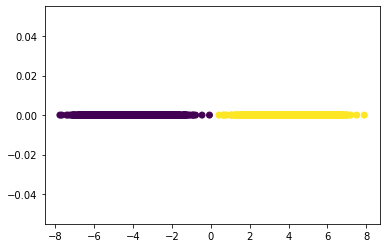

1.0


In [4]:
y_, true_LDA_score, clf = util.scikit_LDA(X, y)
plt.scatter(y_,np.zeros(y_.shape), c = y)
plt.show()
print(true_LDA_score)


In [16]:

def eta(t):
    return 1e-3

def gamma(t):
    return 1e-3

In [ ]:
np.random.seed(1)
LDA, err, metric, optimal = util.run_offline(X, y, m1, m2, cov, true_LDA_score, eta,gamma,epochs=10000)

 84%|████████▎ | 8352/10000 [00:04<00:00, 1763.07it/s]

In [18]:
# Offline Accuracy
Y = LDA.w.T.dot(X.T)
max((np.sum(Y[:,y == 1] > 0) + np.sum(Y[:,y == 0] < 0)), (np.sum(Y[:,y == 0] > 0) + np.sum(Y[:,y == 1] < 0)) )/X.shape[0]

0.9383

In [19]:
# Optimal Accuracy
optimal_W = np.linalg.inv(cov)@(m1-m2)
Y = optimal_W.T.dot(X.T)
max((np.sum(Y[y == 1] > 0) + np.sum(Y[y == 0] < 0)), (np.sum(Y[y == 0] > 0) + np.sum(Y[y == 1] < 0)) )/X.shape[0]

0.9531

In [20]:
optimal[-1]

3.673083270197317

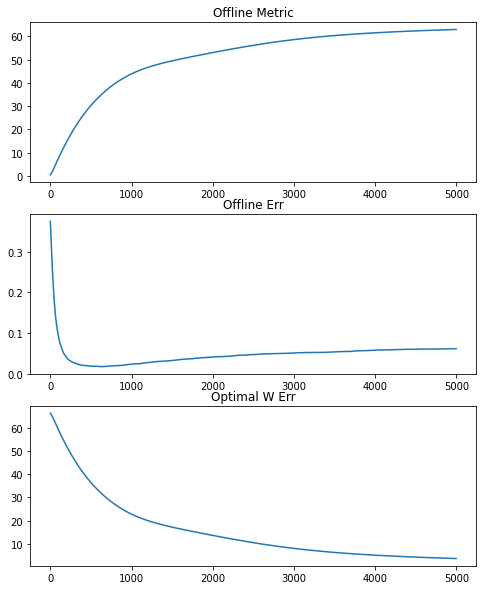

In [21]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()

In [9]:
LDA, err, metric, optimal = util.run_online(X, y, m1, m2, cov,  true_LDA_score, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/aneeshkashalikar/Downloads/bio-lda/bio_lda/lda.py:150: RuntimeWarning: invalid value encountered in add
  w =  w + e_step*(r_a-s_b-l*yhat)*x + e_step*(l*yhat*xbar)
/Users/aneeshkashalikar/Downloads/bio-lda/bio_lda/util.py:75: RuntimeWarning: invalid value encountered in greater
  err.append(true_lda_score - max((np.sum(Y[y == 1] > 0) + np.sum(Y[y == 0] < 0)), (np.sum(Y[y == 0] > 0) + np.sum(Y[y == 1] < 0)) )/10000)
/Users/aneeshkashalikar/Downloads/bio-lda/bio_lda/util.py:75: RuntimeWarning: invalid value encountered in less
  err.append(true_lda_score - max((np.sum(Y[y == 1] > 0) + np.sum(Y[y == 0] < 0)), (np.sum(Y[y == 0] > 0) + np.sum(Y[y == 1] < 0)) )/10000)
 46%|████▌     | 23/50 [00:02<00:02, 10.56it/s]


KeyboardInterrupt: 

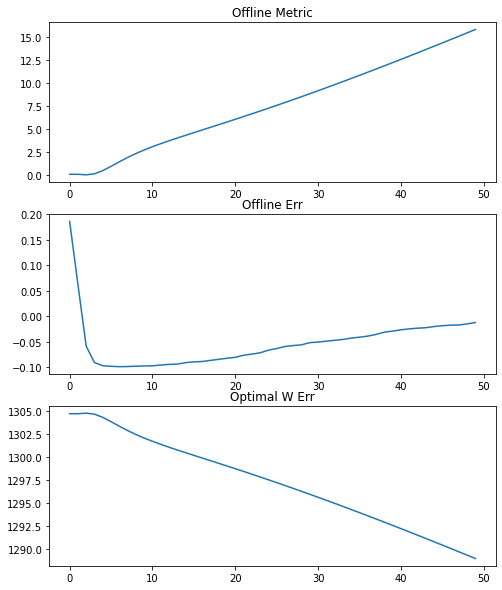

In [168]:
fig, axs = plt.subplots(3,1, figsize=(8,10))

axs[0].plot(metric)
axs[0].set_title("Offline Metric") # Value of W
axs[1].plot(err)
axs[1].set_title("Offline Err") # Accuracy
axs[2].plot(optimal)
axs[2].set_title("Optimal W Err") # Err of W from Optimal W
plt.show()